# Preparation steps

In [7]:
# Install libraries
!pip install sqlalchemy
!pip install pyodbc

In [371]:
# Adding libraries 
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import numpy as np
import scipy.stats as stats
import math as m
import matplotlib.pyplot as plt

In [9]:
# Creating the connection between python and SQL
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows autenthication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [24]:
# Our connection to SQL
engine = new_engine('mssql','QUANGS-HUVUDDAT','AdventureWorks2022', integrated_security=True)
connection = engine.connect()

mssql://QUANGS-HUVUDDAT/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [19]:
#print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [46]:
#Creating a function to print out SQL querys
def Read(Name):
    return pd.read_sql(Name, con=connection)

# Exploring the database of Adventureworks2022 (Deskriptiv sammanfattning)

Adventureworks2022 är en exempel databas över ett företag som säljer cyklar. I databasen går det att hitta olika person information, personregister, personal & HR historik, lönehistorik, försäljningshistorik, butiker, inköpshistorik, cykel komponenter, produktion.

In [47]:
# List of all schemas in adventureworks2022
Explore_Database = """
SELECT *
FROM 
AdventureWorks2022.INFORMATION_SCHEMA.TABLES
ORDER BY 
TABLE_SCHEMA;
"""

Read(Explore_Database)

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,AdventureWorks2022,dbo,DatabaseLog,BASE TABLE
1,AdventureWorks2022,dbo,ErrorLog,BASE TABLE
2,AdventureWorks2022,dbo,AWBuildVersion,BASE TABLE
3,AdventureWorks2022,HumanResources,vEmployee,VIEW
4,AdventureWorks2022,HumanResources,vEmployeeDepartment,VIEW
...,...,...,...,...
86,AdventureWorks2022,Sales,SalesReason,BASE TABLE
87,AdventureWorks2022,Sales,SalesPersonQuotaHistory,BASE TABLE
88,AdventureWorks2022,Sales,SalesOrderDetail,BASE TABLE
89,AdventureWorks2022,Sales,SalesOrderHeaderSalesReason,BASE TABLE


In [68]:
# List of all unique schemas in adventureworks2022
TOT_SCHEMAS = """
SELECT 
DISTINCT TABLE_SCHEMA, COUNT(TABLE_NAME) AS table_count
FROM 
AdventureWorks2022.INFORMATION_SCHEMA.TABLES
GROUP BY 
TABLE_SCHEMA;
"""
Read(TOT_SCHEMAS)

,TABLE_SCHEMA,table_count
0,Person,15
1,Purchasing,7
2,HumanResources,12
3,Sales,26
4,Production,28
5,dbo,3


In [52]:
# The amount of unique orders received from customers
Order_count = """
SELECT 
COUNT(DISTINCT SalesOrderID) AS Orders_received
FROM 
Sales.SalesOrderDetail;"""

Read(Order_count)

,Orders_received
0,31465


In [53]:
# The amount of unique product the company sells to customers
Product_sell = """
SELECT 
COUNT(DISTINCT ProductID) AS Product_Sell
FROM 
Sales.SalesOrderDetail;"""

Read(Product_sell)

,Product_Sell
0,266


In [38]:
# Total orders from each product
TOT_Ordersbyproducts = """
SELECT 
ProductID, SUM(OrderQty) AS Order_quantity
FROM 
Sales.SalesOrderDetail
GROUP 
BY ProductID
ORDER BY 
Order_quantity DESC;"""

Read(TOT_Ordersbyproducts)

,ProductID,Order_quantity
0,712,8311
1,870,6815
2,711,6743
3,715,6592
4,708,6532
...,...,...
261,898,15
262,911,10
263,943,8
264,942,7


In [224]:
# Average quantity, average amount each customer spends
AVG_Order_spentbycustomer = """
SELECT
A.CustomerID,
AVG(B.OrderQty) AS Avg_quantity,
ROUND(AVG(B.LineTotal),2) AS Avg_Amount
FROM 
Sales.SalesOrderHeader AS A
JOIN 
Sales.SalesOrderDetail AS B ON A.SalesOrderID = B.SalesOrderID
GROUP BY 
CustomerID
ORDER BY 
Avg_Amount DESC;"""

Read(AVG_Order_spentbycustomer)

,CustomerID,Avg_quantity,Avg_Amount
0,30111,4,7277.01
1,29621,5,6214.26
2,29624,4,5333.23
3,29861,5,4805.69
4,29710,3,4500.27
...,...,...,...
19114,28094,1,2.29
19115,28781,1,2.29
19116,28968,1,2.29
19117,27991,1,2.29


In [66]:
# Total orders per month
Month_orders = """
SELECT 
FORMAT(OrderDate,'MMMM') AS Month, COUNT(B.SalesOrderID) Order_QTY
FROM 
Sales.SalesOrderHeader AS A
JOIN 
Sales.SalesOrderDetail AS B
ON 
A.SalesOrderID = B.SalesOrderID
GROUP BY 
FORMAT(OrderDate,'MMMM')
ORDER BY 
Order_QTY DESC;
"""

Read(Month_orders)

,Month,Order_QTY
0,March,13899
1,May,13499
2,October,11453
3,July,10961
4,June,10696
5,January,10266
6,September,9611
7,December,9228
8,August,8760
9,April,8346


# Statistics data analysis & confidence interval

4 Analyser kommer utföras

# 1.Average order spent by customers

In [313]:
# Average quantity, average amount each customer spends
AVG_Order_spentbycustomer = """
SELECT
A.CustomerID,
AVG(B.OrderQty) AS Avg_quantity,
ROUND(AVG(B.LineTotal),2) AS Avg_Amount
FROM 
Sales.SalesOrderHeader AS A
JOIN 
Sales.SalesOrderDetail AS B ON A.SalesOrderID = B.SalesOrderID
GROUP BY 
CustomerID
ORDER BY 
Avg_Amount DESC;"""

Read(AVG_Order_spentbycustomer)

,CustomerID,Avg_quantity,Avg_Amount
0,30111,4,7277.01
1,29621,5,6214.26
2,29624,4,5333.23
3,29861,5,4805.69
4,29710,3,4500.27
...,...,...,...
19114,28094,1,2.29
19115,28781,1,2.29
19116,28968,1,2.29
19117,27991,1,2.29


Confidence Interval for Average Order Amount per Customer: (516.4081296059439, 536.7970139685106)


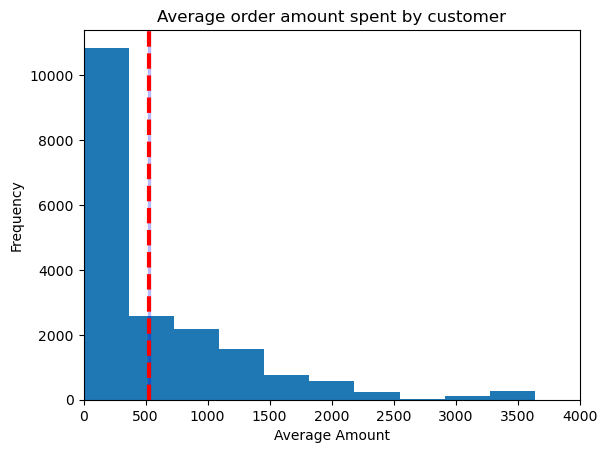

In [383]:
df_Customer = Read(AVG_Order_spentbycustomer)

# Calculate Confidence interval for average order spent by customers
ci = stats.norm.interval(0.95, loc=np.mean(df_Customer.Avg_Amount), scale=stats.sem(df_Customer.Avg_Amount))
print(f"Confidence Interval for Average Order Amount per Customer: {ci}")

# Add labels and title
plt.xlabel('Average Amount')
plt.ylabel('Frequency')
plt.title('Average order amount spent by customer')

#Plotting a histogram from the confidence interval values
plt.hist(df_Customer['Avg_Amount'], bins=20, alpha=1)

#Scale down to appropiate size
plt.xlim(0, 4000)

#Add a vertical line at the mean value
plt.axvline(x=np.mean(df_Customer.Avg_Amount), color='red', linestyle='dashed', linewidth=3)

#Add a shaded region between lower and upper bounds of the confidence interval
plt.axvspan(ci[0], ci[1], alpha=0.2, color='blue')
plt.show()

Genom att ta en titt på kundernas beteende i köp kan vi observera genomsnitts priset de brukar handla för. Detta kan vara en strategi i förberedelser till vilka produkter företaget kan rabattera av för att få in mer kunder då priset är ungefär där kunderna kommer köpa dem. På så sätt kan företagets bild och omdöme förbättras utifrån en kunds perspektiv, därmed blir det bättre sannolikt för företaget att få en solid grund av kundflöde.

 # 2.Orders per month

In [319]:
# Total orders per month
Month_orders = """
SELECT 
FORMAT(OrderDate,'MMMM') AS Month, COUNT(B.SalesOrderID) Order_QTY
FROM 
Sales.SalesOrderHeader AS A
JOIN 
Sales.SalesOrderDetail AS B
ON 
A.SalesOrderID = B.SalesOrderID
GROUP BY 
FORMAT(OrderDate,'MMMM')
ORDER BY 
Order_QTY DESC;
"""

Read(Month_orders)

,Month,Order_QTY
0,March,13899
1,May,13499
2,October,11453
3,July,10961
4,June,10696
5,January,10266
6,September,9611
7,December,9228
8,August,8760
9,April,8346


In [378]:
Month = Read(Month_orders)
df_month = Month.Order_QTY

# Calculate confidence interval for the average order amount per month
ci = stats.norm.interval(0.95, loc=np.mean(df_month), scale=stats.sem(df_month))

Confidence interval for average order per month:(8887.581278667138, 11331.918721332862)


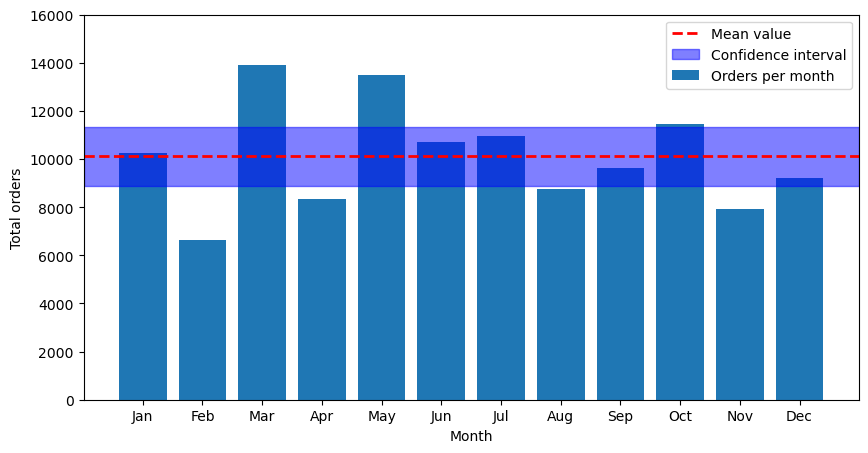

In [382]:
#Create dataset for bar plot
month_data = {'Jan': 10266, 'Feb': 6657, 'Mar': 13899, 'Apr': 8346, 'May': 13499,
              'Jun': 10696, 'Jul': 10961, 'Aug': 8760, 'Sep': 9611, 'Oct': 11453,
             'Nov': 7941, 'Dec': 9228}

names = list(month_data.keys())
values = list(month_data.values())

#plotting a histogram
plt.figure(figsize=(10,5))
plt.bar(names, values, align='center', label='Orders per month')
plt.xlabel('Month')
plt.ylabel('Total orders')
plt.ylim(0,16000)


#adds a vertical line at the mean value
plt.axhline(y=np.mean(values), color='red', linestyle='dashed', linewidth=2, label='Mean value')

#adds a shaded region between lower and upper bounds of the confidence interval
plt.axhspan(ci[0], ci[1], alpha=0.5, color='blue', label='Confidence interval')

plt.legend()
print (f'Confidence interval for average order per month:{ci}')

plt.show()

Att observera hur månaderna ser ut i företaget kan skapa under vilka perioder företaget säljer bäst och satsar att förbereda planer och strategier inför den perioden för att bringa in vinster.

Annan strategi är att kolla på månaderna som prestera sämre och kika in hur företaget skall göra för att förbättra försäljningen där.

In [ ]:
# Annan alternativ till grafen ovan
'''
Month = Read(Month_orders)
df_month = Month.Order_QTY

# Calculate confidence interval for the average order amount per month
ci = stats.norm.interval(0.95, loc=np.mean(df_month), scale=stats.sem(df_month))

print(f"Confidence Interval for Average Order Amount per month: {ci}")

#plotting a histogram from the confidence interval values
plt.figure(figsize =(8,3))
plt.hist(df_month, bins=10, alpha=1, color = 'orange')

# Add labels and title
plt.xlabel('Average Amount')
plt.ylabel('Frequency')
plt.title('Average order amount per month')


#adds a vertical line at the mean value
plt.axvline(x=np.mean(df_month), color='red', linestyle='dashed', linewidth=2)

#adds a shaded region between lower and upper bounds of the confidence interval
plt.axvspan(ci[0], ci[1], alpha=0.2, color='blue')
plt.show()
'''


# 3.Salary vs gender

In [177]:
# Lönen för män och kvinnor
Salary_gender = """
SELECT Gender, Rate

FROM HumanResources.Employee AS A
JOIN HumanResources.EmployeePayHistory AS B
ON A.BusinessEntityID = B.BusinessEntityID
WHERE RateChangeDate = (SELECT MAX(RateChangeDate)   
                        FROM HumanResources.EmployeePayHistory AS A  
                        WHERE A.BusinessEntityID = B.BusinessEntityID);"""
df_gender = Read(Salary_gender)
df_gender

,Gender,Rate
0,M,125.5000
1,F,63.4615
2,M,43.2692
3,M,29.8462
4,F,32.6923
...,...,...
285,F,23.0769
286,F,48.1010
287,F,23.0769
288,F,23.0769


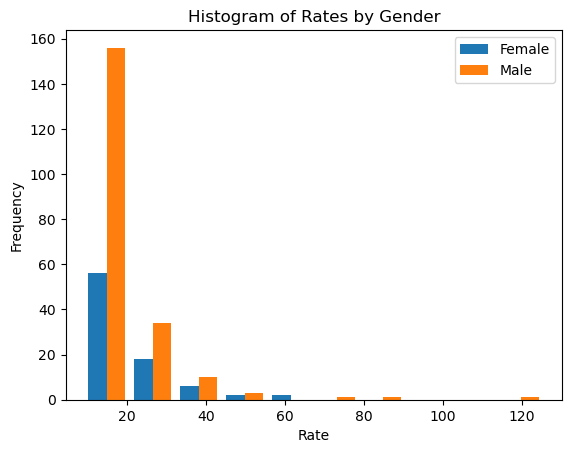

In [296]:
# Create separate dataframes for females and males
females = df_gender[df_gender['Gender'] == 'F']
males = df_gender[df_gender['Gender'] == 'M']

# Create the histogram
plt.hist([females['Rate'], males['Rate']], bins=10, label=['Female', 'Male'])

# Add labels and title
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Rates by Gender')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [299]:
# Average salary for female
Avg_Salary_F = """
WITH Salary_Gender 
AS 
(  SELECT Gender, Rate

FROM HumanResources.Employee AS A
JOIN HumanResources.EmployeePayHistory AS B
ON A.BusinessEntityID = B.BusinessEntityID
WHERE RateChangeDate = (SELECT MAX(RateChangeDate)   
                        FROM HumanResources.EmployeePayHistory AS A  
                        WHERE A.BusinessEntityID = B.BusinessEntityID)

)
SELECT AVG(Rate) AS Avg_Rate_Female
FROM Salary_Gender
Where Gender = 'F';"""

Read(Avg_Salary_F)

,Avg_Rate_Female
0,19.2289


In [300]:
# Average salary for men
Avg_Salary_M = """
WITH Salary_Gender 
AS 
(  SELECT  Gender, Rate

FROM HumanResources.Employee AS A
JOIN HumanResources.EmployeePayHistory AS B
ON A.BusinessEntityID = B.BusinessEntityID
WHERE RateChangeDate = (SELECT MAX(RateChangeDate)   
                        FROM HumanResources.EmployeePayHistory AS A  
                        WHERE A.BusinessEntityID = B.BusinessEntityID)

)
SELECT AVG(Rate) AS Avg_Rate_Men
FROM Salary_Gender
Where Gender = 'M';"""
Read(Avg_Salary_M)

,Avg_Rate_Men
0,17.7638


Lönestatistik över könsrollen. En kort översikt om hur lönen är upplagd i företaget. En aspekt som HR-personal kanske är intresserad över om dem ska rekryterar nya och vill veta lönebudget så löneförhandlingen går bra samt det ska fungera för företaget och den nya rekryten.

En annan tolkning är att observera om lönestatistisken är jämnt fördelat mellan personalen trots deras könsskillnader.

# 3.5 Confidence intervall between gender differences

In [301]:
# Count the number of rows where the gender is F
num_females = len(df_gender[df_gender['Gender'] == 'F'])

print("Number of Females in the company: {}".format(num_females))

Number of Females in the company: 84


In [302]:
# Count the number of rows where the gender is M
num_males = len(df_gender[df_gender['Gender'] == 'M'])

print("Number of Male in the company: {}".format(num_males))

Number of Male in the company: 206


In [309]:
p_men = num_males/(num_females + num_males)
p_females = num_females/(num_females + num_males)
z = 1.96

ci_lower = (p_men - p_females) - z*np.sqrt(p_men*(1-p_men)/(num_females + num_males))
ci_upper = (p_men - p_females) + z*np.sqrt(p_men*(1-p_men)/(num_females + num_males))
print(f'confidence interval between difference in gender:{(ci_lower, ci_upper)}')

confidence interval between difference in gender:(0.3684822236246796, 0.4728970867201479)


Översiktligt konfidens intervall över könsfördelningen i företaget. Eftersom det är noll (minimal skillnad) i talet så uteslutas det att det inte finns någon köns skillnader i företaget.

Annan perspektiv är att företaget inte har någon könsroll som är dominant i sin bransch.

# 4.Age distribution

In [185]:
# Showing the age of all the employees
Employee_year = """
SELECT BirthDate, Gender
FROM HumanResources.Employee
ORDER BY BirthDate;"""
Emp = Read(Employee_year)
Emp

,BirthDate,Gender
0,1951-10-17,M
1,1952-03-02,M
2,1952-05-12,M
3,1952-09-27,F
4,1953-04-30,M
...,...,...
285,1990-11-01,F
286,1990-11-04,M
287,1991-01-04,M
288,1991-04-06,M


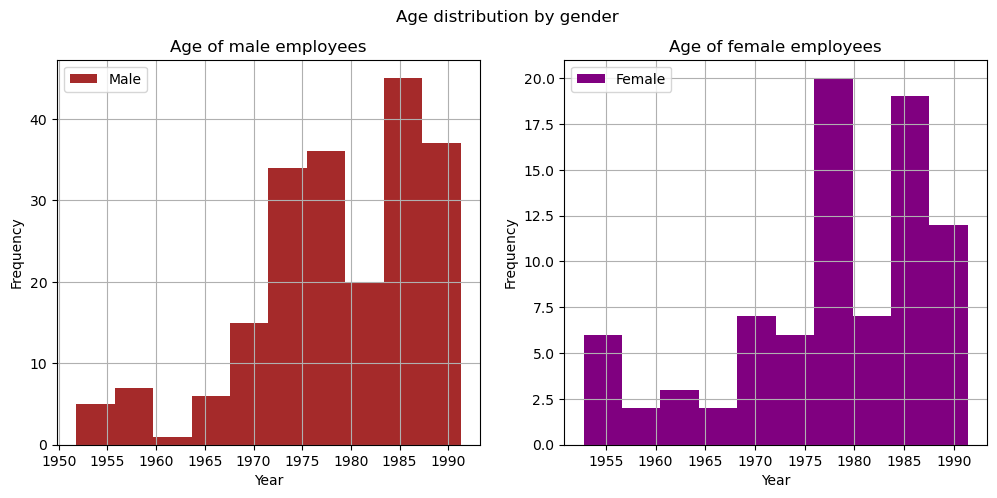

In [377]:
# Sort out the dataframe to include only the rows with Gender F or M
df_male = Emp[Emp['Gender'] == 'M']
df_female = Emp[Emp['Gender'] == 'F']

# Create a figure with two subplots
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Age distribution by gender')

# Plot the male histogram on the first subplot
df_male['BirthDate'].hist(ax=ax1, color='brown')
ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency')
ax1.set_title('Age of male employees')
ax1.legend(['Male'])

# Plot the female histogram on the second subplot
df_female['BirthDate'].hist(ax=ax2, color='purple')
ax2.set_xlabel('Year')
ax2.set_ylabel('Frequency')
ax2.set_title('Age of female employees')
ax2.legend(['Female'], loc='upper left')



Åldersfördelnings graf över könsroll. En vy på hur åldern ser ut i företaget. Detta kan hjälpa företaget att se över åldersfördelningen i företaget och hålla koll när det är dags att rekrytera in mer personal då t.ex nuvarande personal närma sig sin pension.